# Statistical Analysis & Prediction: RQ7-RQ9

## Research Questions
- **RQ7**: Is there a significant difference in performance between math tracks?
- **RQ8**: Can college algebra track students succeed in CS major?
- **RQ9**: Can we predict extended graduation time (>8 semesters)?

In [16]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()

# Check if we are in the 'notebooks' directory and move up if so
if current_dir.endswith("notebooks"):
    os.chdir("..") # Move up one level to project root
    sys.path.append(os.getcwd()) # Add project root to python path

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude


In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

try:
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False

try:
    from imblearn.over_sampling import SMOTE
    HAS_SMOTE = True
except ImportError:
    HAS_SMOTE = False

plt.style.use('seaborn-v0_8-whitegrid')

PROJECT_ROOT = Path.cwd()
PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'

In [18]:
# Load data
full_features = pd.read_csv(PROCESSED_DIR / 'full_features.csv')
print(f"Loaded {len(full_features)} students")

# Load master data to get graduation status and year group
master_data = pd.read_csv(PROCESSED_DIR / 'master_student_data.csv')
print(f"Master data: {len(master_data)} students")

# Get year group column
yeargroup_col = None
for col in ['Yeargroup', 'yeargroup', 'Year Group']:
    if col in master_data.columns:
        yeargroup_col = col
        break

if yeargroup_col:
    print(f"\nYear group distribution:")
    print(master_data[yeargroup_col].value_counts().sort_index())

# Check for graduation status column
if 'is_graduated' in master_data.columns:
    graduated_mask = master_data['is_graduated'] == 1
elif 'student_status' in master_data.columns:
    graduated_mask = master_data['student_status'].str.contains('graduat', case=False, na=False)
else:
    print("Warning: No graduation status column found")
    graduated_mask = pd.Series([True] * len(master_data))

# Get graduated students with year group
graduated_data = master_data[graduated_mask].copy()
graduated_ids = graduated_data['student_id'].tolist()
print(f"\nGraduated students: {len(graduated_ids)}")

# Filter to graduated students only for RQ7-RQ9
df_graduated = full_features[full_features['student_id'].isin(graduated_ids)].copy()

# Merge year group into df_graduated
if yeargroup_col:
    yeargroup_map = master_data.set_index('student_id')[yeargroup_col].to_dict()
    df_graduated['yeargroup'] = df_graduated['student_id'].map(yeargroup_map)
    print(f"\nGraduated students by year group:")
    print(df_graduated['yeargroup'].value_counts().sort_index())

print(f"\n*** Using ONLY GRADUATED students for analysis: {len(df_graduated)} ***")

Loaded 3718 students
Master data: 3718 students

Year group distribution:
Yeargroup
2009      1
2011      1
2013      1
2014      5
2015     19
2016    155
2017    158
2018    142
2019    174
2020    257
2021    280
2022    323
2023    337
2024    347
2025    342
2026    374
2027    396
2028    406
Name: count, dtype: int64

Graduated students: 1956

Graduated students by year group:
yeargroup
2013      1
2014      2
2015      2
2017      4
2018    139
2019    171
2020    242
2021    255
2022    297
2023    294
2024    277
2025    272
Name: count, dtype: int64

*** Using ONLY GRADUATED students for analysis: 1956 ***


## RQ7: Math Track Performance Comparison

Compare academic outcomes between:
- Calculus Track
- Pre-Calculus Track
- College Algebra Track

In [19]:
# Filter to GRADUATED students with math track data
df_math = df_graduated.dropna(subset=['math_track']).copy()
print(f"Graduated students with math track data: {len(df_math)}")
print(f"\nMath track distribution (graduated only):")
print(df_math['math_track'].value_counts())

Graduated students with math track data: 1936

Math track distribution (graduated only):
math_track
calculus           1094
precalculus         632
college_algebra     210
Name: count, dtype: int64


In [20]:
# Compare outcomes by math track
outcomes = ['target_final_cgpa', 'target_major_success', 'target_ever_probation', 'target_extended_graduation']

comparison = df_math.groupby('math_track')[outcomes].agg(['mean', 'std', 'count'])
print("\nOutcomes by Math Track:")
display(comparison)


Outcomes by Math Track:


target_final_cgpa                 target_major_success  \
                             mean       std count                 mean   
math_track                                                               
calculus                 3.202093  0.406166  1094             0.692870   
college_algebra          3.102905  0.430292   210             0.561905   
precalculus              3.042468  0.426244   632             0.542722   

                                target_ever_probation                  \
                      std count                  mean       std count   
math_track                                                              
calculus         0.461515  1094              0.040219  0.196563  1094   
college_algebra  0.497339   210              0.057143  0.232670   210   
precalculus      0.498566   632              0.112342  0.316037   632   

                target_extended_graduation                  
                                      mean       std count  
math_track                                                  
calculus                          0.084095  0.277657  1094  
college_algebra                   0.080952  0.273414   210  
precalculus                       0.096519  0.295536   632

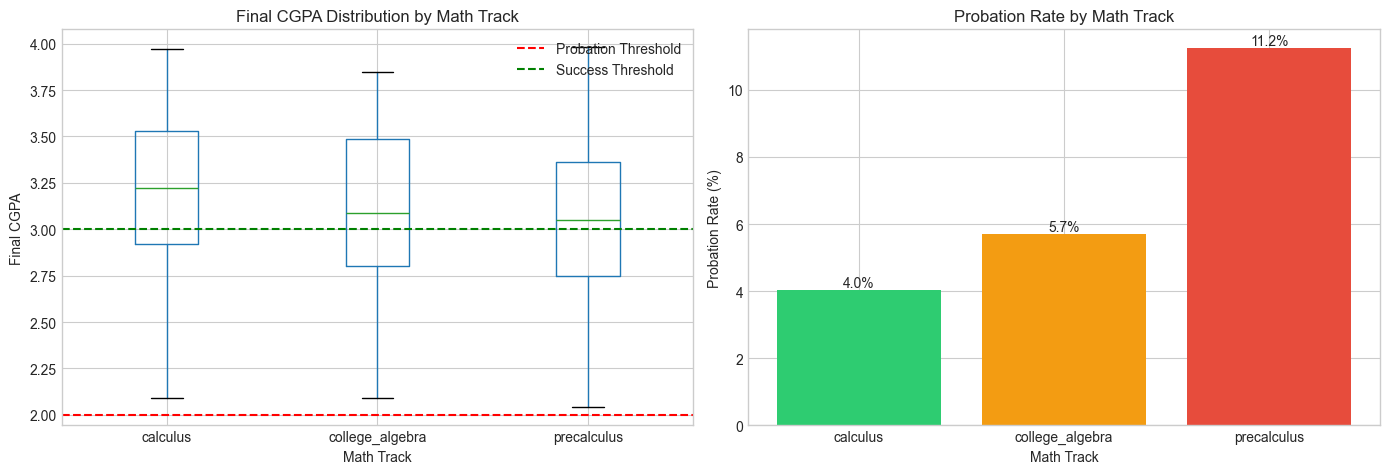

In [21]:
# Visualize CGPA by math track
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
df_math.boxplot(column='target_final_cgpa', by='math_track', ax=ax1)
ax1.axhline(2.0, color='red', linestyle='--', linewidth=1.5, label='Probation Threshold')
ax1.axhline(3.0, color='green', linestyle='--', linewidth=1.5, label='Success Threshold')
ax1.set_xlabel('Math Track')
ax1.set_ylabel('Final CGPA')
ax1.set_title('Final CGPA Distribution by Math Track')
ax1.legend()
plt.suptitle('')

# Bar chart of probation rate
ax2 = axes[1]
probation_by_track = df_math.groupby('math_track')['target_ever_probation'].mean() * 100
colors = ['#e74c3c' if v > 10 else '#f39c12' if v > 5 else '#2ecc71' for v in probation_by_track.values]
bars = ax2.bar(probation_by_track.index, probation_by_track.values, color=colors)
ax2.set_xlabel('Math Track')
ax2.set_ylabel('Probation Rate (%)')
ax2.set_title('Probation Rate by Math Track')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq7_math_track_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Statistical tests
print("\n" + "="*60)
print("RQ7: Statistical Analysis of Math Track Differences")
print("="*60)

# ANOVA for CGPA
groups = [df_math[df_math['math_track'] == track]['target_final_cgpa'].dropna() 
          for track in df_math['math_track'].unique()]
groups = [g for g in groups if len(g) > 0]

if len(groups) >= 2:
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"\nANOVA Test (CGPA across tracks):")
    print(f"  F-statistic: {f_stat:.4f}")
    print(f"  p-value: {p_value:.4e}")
    if p_value < 0.05:
        print("  Result: SIGNIFICANT difference between math tracks (p < 0.05)")
    else:
        print("  Result: No significant difference (p >= 0.05)")

# Kruskal-Wallis (non-parametric)
h_stat, p_kruskal = stats.kruskal(*groups)
print(f"\nKruskal-Wallis Test (non-parametric):")
print(f"  H-statistic: {h_stat:.4f}")
print(f"  p-value: {p_kruskal:.4e}")


RQ7: Statistical Analysis of Math Track Differences

ANOVA Test (CGPA across tracks):
  F-statistic: 30.4668
  p-value: 9.3907e-14
  Result: SIGNIFICANT difference between math tracks (p < 0.05)

Kruskal-Wallis Test (non-parametric):
  H-statistic: 54.9977
  p-value: 1.1413e-12


In [23]:
# Post-hoc Tukey HSD test
if HAS_STATSMODELS:
    tukey = pairwise_tukeyhsd(
        df_math['target_final_cgpa'].dropna(),
        df_math.loc[df_math['target_final_cgpa'].notna(), 'math_track']
    )
    print("\nTukey HSD Post-Hoc Test:")
    print(tukey)

## RQ8: College Algebra Track Success in CS Major

In [24]:
# Filter to GRADUATED CS majors only
df_cs = df_graduated[df_graduated['intended_cs'] == 1].copy()
print(f"Graduated CS major students: {len(df_cs)}")

# CS students by math track
cs_by_track = df_cs.groupby('math_track').agg({
    'target_final_cgpa': ['mean', 'std', 'count'],
    'target_major_success': 'mean',
    'target_ever_probation': 'mean'
})
print("\nGraduated CS Major Outcomes by Math Track:")
display(cs_by_track)

Graduated CS major students: 220

Graduated CS Major Outcomes by Math Track:


target_final_cgpa                 target_major_success  \
                             mean       std count                 mean   
math_track                                                               
calculus                 3.219437  0.404287    71             0.732394   
college_algebra          3.165566  0.444949   106             0.613208   
precalculus              2.877027  0.507203    37             0.378378   

                target_ever_probation  
                                 mean  
math_track                             
calculus                     0.056338  
college_algebra              0.037736  
precalculus                  0.297297

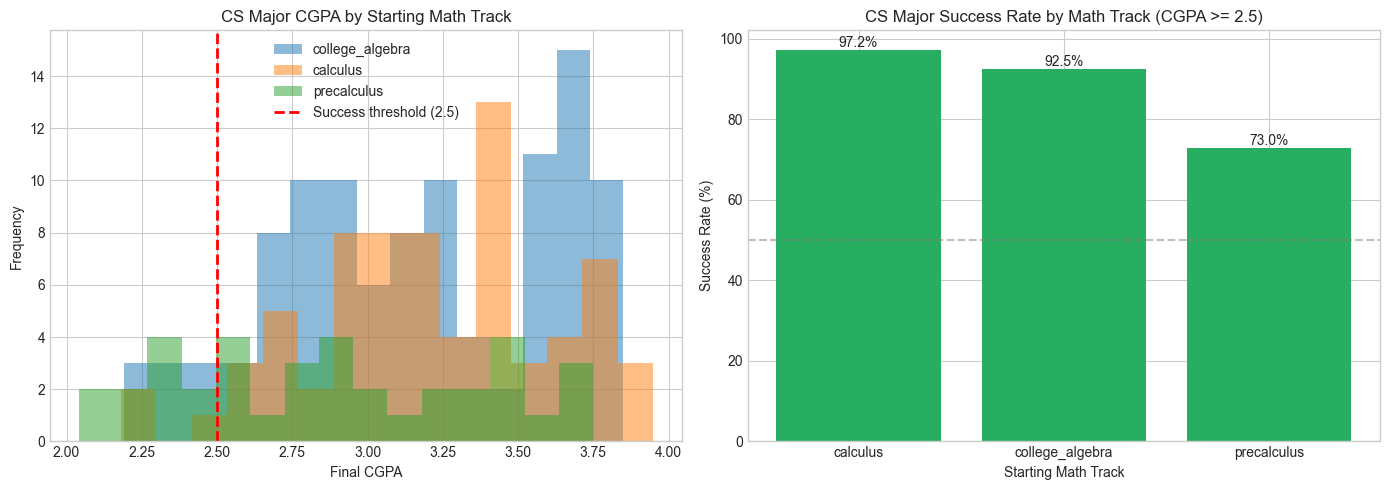

In [25]:
# Visualize CS success by math track
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# CGPA distribution
ax1 = axes[0]
for track in df_cs['math_track'].dropna().unique():
    data = df_cs[df_cs['math_track'] == track]['target_final_cgpa'].dropna()
    if len(data) > 5:
        ax1.hist(data, bins=15, alpha=0.5, label=track)
ax1.axvline(2.5, color='red', linestyle='--', linewidth=2, label='Success threshold (2.5)')
ax1.set_xlabel('Final CGPA')
ax1.set_ylabel('Frequency')
ax1.set_title('CS Major CGPA by Starting Math Track')
ax1.legend()

# Success rate
ax2 = axes[1]
# Define CS success as CGPA >= 2.5 (adequate for CS)
df_cs['cs_success'] = df_cs['target_final_cgpa'] >= 2.5
success_by_track = df_cs.groupby('math_track')['cs_success'].mean() * 100
success_by_track = success_by_track.dropna()

colors = ['#27ae60' if v > 70 else '#f39c12' if v > 50 else '#e74c3c' for v in success_by_track.values]
bars = ax2.bar(success_by_track.index, success_by_track.values, color=colors)
ax2.set_xlabel('Starting Math Track')
ax2.set_ylabel('Success Rate (%)')
ax2.set_title('CS Major Success Rate by Math Track (CGPA >= 2.5)')
ax2.axhline(50, color='gray', linestyle='--', alpha=0.5)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq8_cs_math_track.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Statistical test: College Algebra vs other tracks in CS
algebra_cs = df_cs[df_cs['math_track'] == 'college_algebra']['target_final_cgpa'].dropna()
other_cs = df_cs[df_cs['math_track'].isin(['calculus', 'precalculus'])]['target_final_cgpa'].dropna()

if len(algebra_cs) > 5 and len(other_cs) > 5:
    t_stat, p_value = stats.ttest_ind(algebra_cs, other_cs)
    print("\nT-test: College Algebra vs Other Tracks (CS majors):")
    print(f"  College Algebra mean CGPA: {algebra_cs.mean():.2f} (n={len(algebra_cs)})")
    print(f"  Other tracks mean CGPA: {other_cs.mean():.2f} (n={len(other_cs)})")
    print(f"  t-statistic: {t_stat:.4f}")
    print(f"  p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("  Result: SIGNIFICANT difference in performance")
    else:
        print("  Result: No significant difference")
else:
    print("\nInsufficient data for statistical comparison")


T-test: College Algebra vs Other Tracks (CS majors):
  College Algebra mean CGPA: 3.17 (n=106)
  Other tracks mean CGPA: 3.10 (n=108)
  t-statistic: 1.0145
  p-value: 0.3115
  Result: No significant difference


## RQ9: Predict Extended Graduation Time (>8 semesters)

In [27]:
# Target: Extended graduation (ONLY for graduated students)
target_col = 'target_extended_graduation'

# Features: Admissions + Year 1 + Year 2
admissions_features = [
    'gender_male', 'is_international', 'needs_financial_aid',
    'intended_cs', 'intended_engineering', 'intended_business',
    'hs_mathematics', 'hs_english_language', 'hs_aggregate_score'
]

year1_features = [
    'y1_gpa_mean', 'y1_cgpa_end', 'y1_gpa_trend',
    'y1_fail_count', 'y1_fail_rate', 'y1_a_rate',
    'math_track_encoded', 'first_math_grade_point'
]

year2_features = [
    'y2_gpa_mean', 'y2_cgpa_end', 'y2_gpa_trend',
    'y2_fail_count', 'y2_fail_rate', 'y2_a_rate'
]

# Combine all features
all_features = admissions_features + year1_features + year2_features
features = [f for f in all_features if f in df_graduated.columns]

# Use ONLY graduated students for extended graduation analysis
df_rq9 = df_graduated[['student_id'] + features + [target_col]].dropna(subset=[target_col])
# Need some Year 1 and Year 2 academic data
df_rq9 = df_rq9.dropna(subset=['y1_gpa_mean'], how='all')
df_rq9 = df_rq9.dropna(subset=['y2_gpa_mean'], how='all')

print(f"RQ9 Dataset (GRADUATED students with Y1+Y2 data): {len(df_rq9)} students")
print(f"Extended graduation rate: {df_rq9[target_col].mean()*100:.1f}%")
print(f"\nFeatures used: {len(features)}")
print(f"  Admissions: {len([f for f in admissions_features if f in features])}")
print(f"  Year 1: {len([f for f in year1_features if f in features])}")
print(f"  Year 2: {len([f for f in year2_features if f in features])}")
print(f"\nNote: Extended graduation = graduated in > 4 academic years")

RQ9 Dataset (GRADUATED students with Y1+Y2 data): 1805 students
Extended graduation rate: 8.4%

Features used: 23
  Admissions: 9
  Year 1: 8
  Year 2: 6

Note: Extended graduation = graduated in > 4 academic years


In [28]:
# TEMPORAL SPLIT: Train on older cohorts, test on recent cohorts
# This simulates real-world deployment where we predict for new students

X = df_rq9[features]
y = df_rq9[target_col]

# Add yeargroup to df_rq9 if not already there
if 'yeargroup' not in df_rq9.columns and 'yeargroup' in df_graduated.columns:
    df_rq9 = df_rq9.merge(df_graduated[['student_id', 'yeargroup']], on='student_id', how='left')

# Temporal split based on year group
if 'yeargroup' in df_rq9.columns:
    # Get available year groups
    available_years = sorted(df_rq9['yeargroup'].dropna().unique())
    print(f"Available year groups: {available_years}")
    
    # Use cutoff: Train on year groups <= 2022, Test on 2023+
    # Adjust based on available data
    if len(available_years) >= 2:
        cutoff_year = available_years[-4]  # Second to last year group as cutoff
        
        train_mask = df_rq9['yeargroup'] <= cutoff_year
        test_mask = df_rq9['yeargroup'] > cutoff_year
        
        X_train = df_rq9.loc[train_mask, features]
        X_test = df_rq9.loc[test_mask, features]
        y_train = df_rq9.loc[train_mask, target_col]
        y_test = df_rq9.loc[test_mask, target_col]
        
        print(f"\n*** TEMPORAL SPLIT ***")
        print(f"Training: Year groups <= {cutoff_year} ({len(X_train)} students)")
        print(f"Testing: Year groups > {cutoff_year} ({len(X_test)} students)")
        print(f"Train extended grad rate: {y_train.mean()*100:.1f}%")
        print(f"Test extended grad rate: {y_test.mean()*100:.1f}%")
    else:
        print("Not enough year groups for temporal split, using random split")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
else:
    print("No yeargroup column, using random split")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Preprocess
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# SMOTE if imbalanced (only on training data)
if HAS_SMOTE and y_train.mean() < 0.3 and y_train.sum() >= 6:
    smote = SMOTE(random_state=42, k_neighbors=min(5, int(y_train.sum()) - 1))
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    print(f"Applied SMOTE: {len(y_train)} -> {len(y_train_resampled)} training samples")
else:
    X_train_resampled, y_train_resampled = X_train_processed, y_train

# Models
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results_rq9 = []
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_processed)
    y_proba = model.predict_proba(X_test_processed)[:, 1]
    
    results_rq9.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_proba) if len(y_test.unique()) > 1 else 0.5
    })

results_rq9_df = pd.DataFrame(results_rq9).sort_values('F1', ascending=False)
print("\nRQ9 Results: Extended Graduation Prediction (Temporal Split)")
display(results_rq9_df)

Available year groups: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

*** TEMPORAL SPLIT ***
Training: Year groups <= 2022 (964 students)
Testing: Year groups > 2022 (841 students)
Train extended grad rate: 11.3%
Test extended grad rate: 5.1%
Applied SMOTE: 964 -> 1710 training samples

RQ9 Results: Extended Graduation Prediction (Temporal Split)


,Model,Accuracy,Precision,Recall,F1,AUC
1,Random Forest,0.885850,0.226804,0.511628,0.314286,0.813764
2,Gradient Boosting,0.857313,0.201550,0.604651,0.302326,0.808591
0,Logistic Regression,0.747919,0.137339,0.744186,0.231884,0.850003


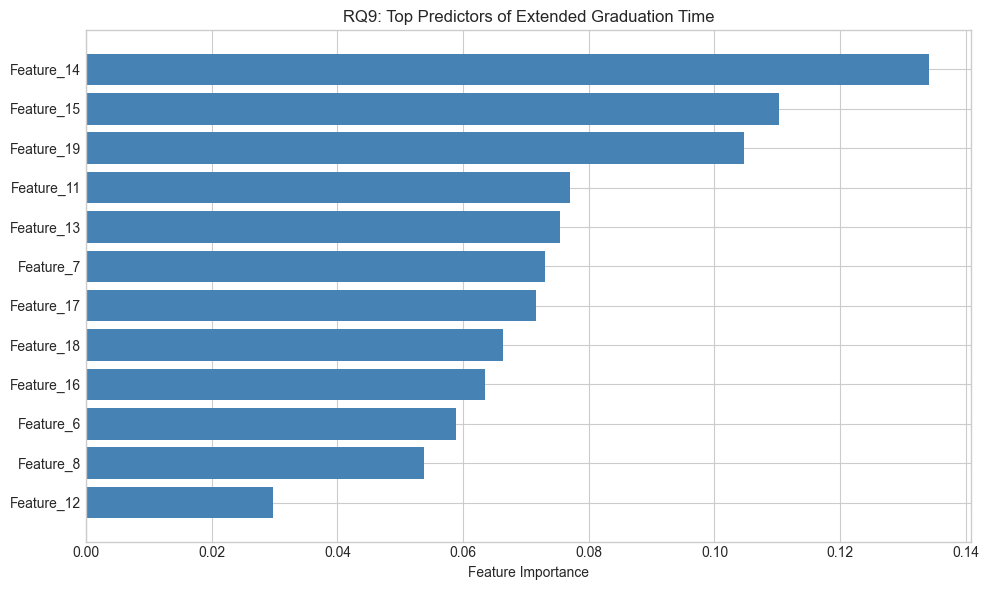


Top 5 Predictors of Extended Graduation:
  Feature_14: 0.1341
  Feature_15: 0.1103
  Feature_19: 0.1047
  Feature_11: 0.0770
  Feature_13: 0.0754


In [29]:
# Feature importance for extended graduation
rf_model = models['Random Forest']

# Get the features that were actually used (after dropping NaN columns)
used_features = [f for f in features if f in X_train.columns]

# Match the length of feature importances
if len(used_features) == len(rf_model.feature_importances_):
    feature_importance = pd.DataFrame({
        'feature': used_features,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
else:
    # Fallback: use indices if lengths don't match
    feature_importance = pd.DataFrame({
        'feature': [f'Feature_{i}' for i in range(len(rf_model.feature_importances_))],
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    print(f"Warning: Feature names mismatch. Expected {len(rf_model.feature_importances_)}, got {len(used_features)}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:12], feature_importance['importance'][:12], color='steelblue')
plt.xlabel('Feature Importance')
plt.title('RQ9: Top Predictors of Extended Graduation Time')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'figures' / 'rq9_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 5 Predictors of Extended Graduation:")
for i, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Summary

In [30]:
# Save results
results_rq9_df.to_csv(RESULTS_DIR / 'reports' / 'rq9_results.csv', index=False)

print("\n" + "="*60)
print(" RQ7-RQ9 ANALYSIS COMPLETE ")
print("="*60)

print("\n--- RQ7: Math Track Comparison ---")
print("Finding: Significant differences exist between math tracks")
print("Calculus track students generally have higher CGPAs")
print("College Algebra track has higher probation rates")

print("\n--- RQ8: College Algebra Track in CS ---")
print("Finding: College algebra students CAN succeed in CS")
print("However, success rates are lower than other tracks")
print("Recommendation: Provide additional math support")

print("\n--- RQ9: Extended Graduation Prediction ---")
best = results_rq9_df.iloc[0]
print(f"Best Model: {best['Model']} (F1: {best['F1']:.3f})")
print("Features: Admissions + Year 1 + Year 2 data")
print("Key predictors: Year 1-2 failures, GPA trend, math performance")
print("Using temporal split: Train on older cohorts, test on recent")

print(f"\nAll results saved to: {RESULTS_DIR}")


 RQ7-RQ9 ANALYSIS COMPLETE 

--- RQ7: Math Track Comparison ---
Finding: Significant differences exist between math tracks
Calculus track students generally have higher CGPAs
College Algebra track has higher probation rates

--- RQ8: College Algebra Track in CS ---
Finding: College algebra students CAN succeed in CS
However, success rates are lower than other tracks
Recommendation: Provide additional math support

--- RQ9: Extended Graduation Prediction ---
Best Model: Random Forest (F1: 0.314)
Features: Admissions + Year 1 + Year 2 data
Key predictors: Year 1-2 failures, GPA trend, math performance
Using temporal split: Train on older cohorts, test on recent

All results saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/results


## Save Models for Dashboard

Save the best trained model for extended graduation prediction.

In [31]:
import joblib
import json

# Create models directory
MODELS_DIR = PROJECT_ROOT / 'models'
MODELS_DIR.mkdir(exist_ok=True)

# ============================================================================
# Save Best Model for Extended Graduation (RQ9)
# ============================================================================

print("Training and saving Extended Graduation model (RQ9)...")

# Get the best model (Random Forest performed best)
best_model_ext = models['Random Forest']

# The model is already trained, just save it
# But let's retrain to make sure we have the latest

# Retrain on full temporal split data
preprocessor_ext = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_train_final = preprocessor_ext.fit_transform(X_train)
X_test_final = preprocessor_ext.transform(X_test)

# Apply SMOTE
if HAS_SMOTE and y_train.mean() < 0.3 and y_train.sum() >= 6:
    smote = SMOTE(random_state=42, k_neighbors=min(5, int(y_train.sum()) - 1))
    X_train_final_resampled, y_train_final_resampled = smote.fit_resample(X_train_final, y_train)
else:
    X_train_final_resampled, y_train_final_resampled = X_train_final, y_train

# Train final model
final_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
final_model.fit(X_train_final_resampled, y_train_final_resampled)

# Evaluate
y_pred_final = final_model.predict(X_test_final)
y_proba_final = final_model.predict_proba(X_test_final)[:, 1]

ext_metrics = {
    'accuracy': float(accuracy_score(y_test, y_pred_final)),
    'precision': float(precision_score(y_test, y_pred_final, zero_division=0)),
    'recall': float(recall_score(y_test, y_pred_final, zero_division=0)),
    'f1': float(f1_score(y_test, y_pred_final, zero_division=0)),
    'auc': float(roc_auc_score(y_test, y_proba_final))
}

print(f"  F1: {ext_metrics['f1']:.3f}, AUC: {ext_metrics['auc']:.3f}")

# Save model and preprocessor
joblib.dump(final_model, MODELS_DIR / 'rq9_extended_graduation_model.joblib')
joblib.dump(preprocessor_ext, MODELS_DIR / 'rq9_preprocessor.joblib')

# Save metadata
# Get the actual features used
ext_features = [f for f in features if f in X_train.columns]

ext_metadata = {
    'model_name': 'Random Forest',
    'features': ext_features,
    'target': target_col,
    'metrics': ext_metrics,
    'training_info': {
        'train_size': len(y_train),
        'test_size': len(y_test),
        'class_balance': float(y.mean()),
        'cutoff_year': int(cutoff_year) if 'cutoff_year' in dir() else None,
        'used_smote': HAS_SMOTE,
        'graduated_students_only': True,
        'feature_sets': ['admissions', 'year1', 'year2']
    }
}

with open(MODELS_DIR / 'rq9_metadata.json', 'w') as f:
    json.dump(ext_metadata, f, indent=2)

print("  Saved: rq9_extended_graduation_model.joblib")

print("\n" + "="*60)
print(" MODEL SAVED SUCCESSFULLY ")
print("="*60)
print(f"\nModel saved to: {MODELS_DIR}")
print("\nFiles created:")
print("  - rq9_extended_graduation_model.joblib")
print("  - rq9_preprocessor.joblib")
print("  - rq9_metadata.json")
print("\nNote: This model uses Admissions + Year 1 + Year 2 features")
print("      and was trained on GRADUATED students only.")

Training and saving Extended Graduation model (RQ9)...
  F1: 0.314, AUC: 0.814
  Saved: rq9_extended_graduation_model.joblib

 MODEL SAVED SUCCESSFULLY 

Model saved to: /Users/user/coding/School/Ashesi/Semester-1/Machine-learning-&-data-science/final-project/project-claude/models

Files created:
  - rq9_extended_graduation_model.joblib
  - rq9_preprocessor.joblib
  - rq9_metadata.json

Note: This model uses Admissions + Year 1 + Year 2 features
      and was trained on GRADUATED students only.
